In [225]:
import pandas as pd
import numpy as np
#from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from datetime import date
import time
plt.style.use('ggplot')

In [226]:
#read the csv into a pandas dataframe
df = pd.read_csv('/Users/raffi/Desktop/galvanize/capstone_1/data/games.csv', delimiter = ',')

In [228]:
#dropping duplicated ids in dataframe
df.drop_duplicates(subset = ['id'], inplace = True)

In [229]:
#update moves column from string to list for future analysis
df.moves = df.moves.apply(lambda x: x.split(' '))

In [230]:
#categorize rating scale - 1517 below 1200, 12668 between 1400 - 2000, 1716 above 2000
#https://en.wikipedia.org/wiki/Chess_rating_system
#https://en.wikipedia.org/wiki/Elo_rating_system
#beginner < 1400 : 4729
#novice 1200 - 1999 : 12668
#expert 2000 - 2200 : 1169
#master > 2200 : 547

#df[(df['white_rating'] >= 2000) & (df['white_rating'] < 2200)].count()
#df[df['white_rating'] >= 2200].count()
#df[df['white_rating'] < 1400].count()

#categorize rating scales
def rating_cat_value(val):
    if val < 1400:
        return 'Beginner'
    elif val < 2000:
        return 'Novice'
    elif val < 2200:
        return 'Expert'
    elif val >= 2200:
        return 'Master'
    
def rating_cat_code(val):
    if val < 1400:
        return 1
    elif val < 2000:
        return 2
    elif val < 2200:
        return 3
    elif val >= 2200:
        return 4

df['white_rating_value'] = df['white_rating'].apply(rating_cat_value)
df['black_rating_value'] = df['black_rating'].apply(rating_cat_value)
df['white_rating_code'] = df['white_rating'].apply(rating_cat_code)
df['black_rating_code'] = df['black_rating'].apply(rating_cat_code)

In [232]:
#adding new column of data - date
date = pd.to_datetime(df['created_at'], errors = 'ignore', unit = 'ms')
df['date'] = pd.DatetimeIndex(date).date

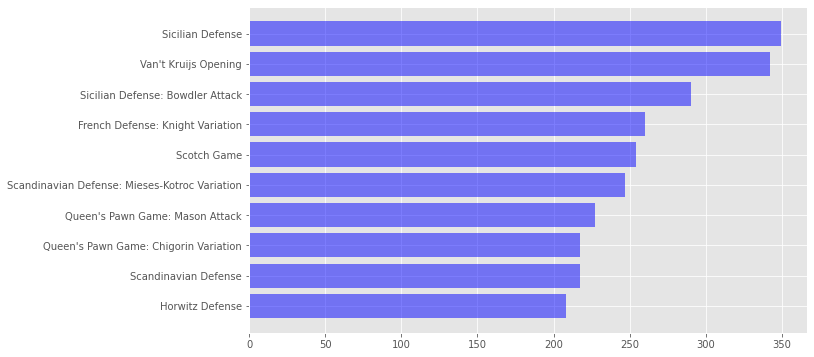

In [233]:
#top 10 openings
openings = df['opening_name'].value_counts()
fig, ax = plt.subplots(1,1, figsize = (10,6))
x_pos = [i for i in openings.index[0:10]]
arr = np.array(openings[0:10])
ax.barh(x_pos, arr, color = 'b', alpha = 0.5)
ax.set_ylim(ax.get_ylim()[::-1]);

In [234]:
openings_grouped = df.groupby(['opening_name', 'white_rating_value'])['id'].count()
openings_grouped = pd.DataFrame(openings_grouped).reset_index()
openings_grouped = openings_grouped.pivot(index = 'opening_name', columns = 'white_rating_value', values = 'id')
openings_grouped.fillna(0, inplace = True)
openings_grouped['total'] = openings_grouped['Beginner'] + openings_grouped['Expert'] + openings_grouped['Novice'] + openings_grouped['Master']
openings_grouped.sort_values(by = 'total', ascending = False, inplace = True)
openings_grouped[0:10]

white_rating_value,Beginner,Expert,Master,Novice,total
opening_name,,,,,
Sicilian Defense,95.0,12.0,2.0,240.0,349.0
Van't Kruijs Opening,228.0,2.0,0.0,112.0,342.0
Sicilian Defense: Bowdler Attack,45.0,4.0,0.0,241.0,290.0
French Defense: Knight Variation,63.0,6.0,0.0,191.0,260.0
Scotch Game,61.0,5.0,3.0,185.0,254.0
Scandinavian Defense: Mieses-Kotroc Variation,79.0,10.0,7.0,151.0,247.0
Queen's Pawn Game: Mason Attack,35.0,8.0,8.0,176.0,227.0
Scandinavian Defense,134.0,3.0,0.0,80.0,217.0
Queen's Pawn Game: Chigorin Variation,81.0,11.0,3.0,122.0,217.0


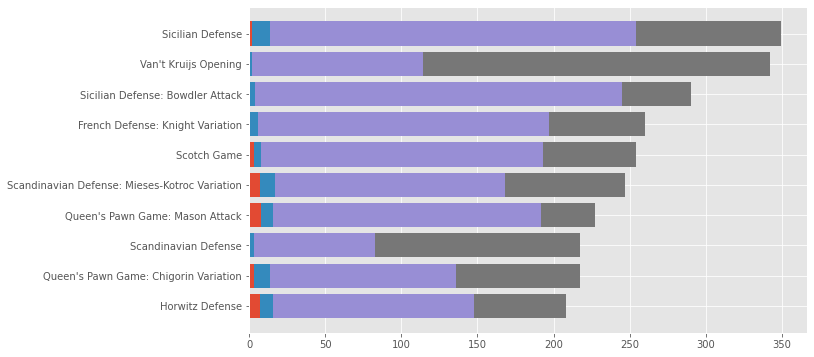

In [235]:
#top 10 most frequent openings played by ranking group
fig, ax = plt.subplots(1,1, figsize = (10,6))
x_pos = [i for i in openings_grouped.index[0:10]]
b = np.array(openings_grouped['Beginner'][0:10])
n = np.array(openings_grouped['Novice'][0:10])
e = np.array(openings_grouped['Expert'][0:10])
m = np.array(openings_grouped['Master'][0:10])
ax.barh(x_pos, m)
ax.barh(x_pos, e, left = m)
ax.barh(x_pos, n, left = m + e)
ax.barh(x_pos, b, left = m + e + n)
ax.set_ylim(ax.get_ylim()[::-1]);

In [236]:
openings_grouped.sort_values(by = 'Master', ascending = False, inplace = True)
openings_grouped

white_rating_value,Beginner,Expert,Master,Novice,total
opening_name,,,,,
Indian Game,19.0,9.0,9.0,140.0,177.0
Saragossa Opening,16.0,0.0,8.0,26.0,50.0
Queen's Pawn Game: Mason Attack,35.0,8.0,8.0,176.0,227.0
Horwitz Defense,60.0,9.0,7.0,132.0,208.0
Queen's Pawn Game: London System,7.0,10.0,7.0,51.0,75.0
...,...,...,...,...,...
King's Gambit Declined | Classical Variation,0.0,1.0,0.0,4.0,5.0
Four Knights Game: Italian Variation | Noa Gambit,0.0,0.0,0.0,5.0,5.0
Indian Game: Wade-Tartakower Defense,2.0,1.0,0.0,2.0,5.0


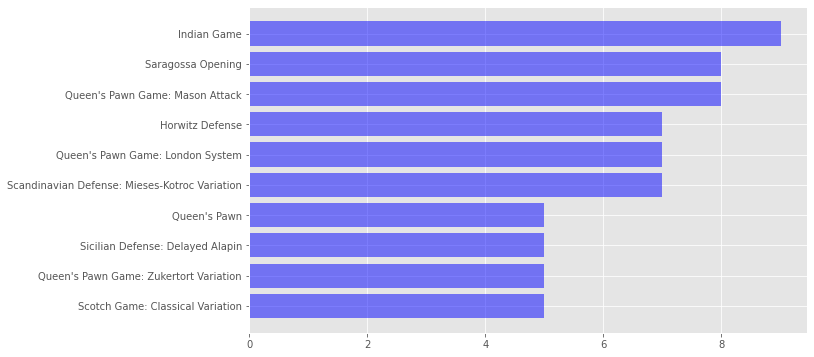

In [237]:
#top 10 openings for masters
fig, ax = plt.subplots(1,1, figsize = (10,6))
x_pos = [i for i in openings_grouped.index[0:10]]
arr = np.array(openings_grouped['Master'][0:10])
ax.barh(x_pos, arr, color = 'b', alpha = 0.5)
ax.set_ylim(ax.get_ylim()[::-1]);

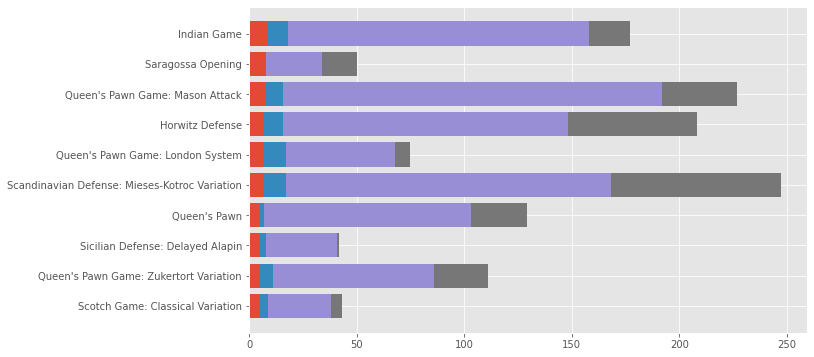

In [238]:
#top 10 most frequent master openings played by ranking group
fig, ax = plt.subplots(1,1, figsize = (10,6))
x_pos = [i for i in openings_grouped.index[0:10]]
b = np.array(openings_grouped['Beginner'][0:10])
n = np.array(openings_grouped['Novice'][0:10])
e = np.array(openings_grouped['Expert'][0:10])
m = np.array(openings_grouped['Master'][0:10])
ax.barh(x_pos, m)
ax.barh(x_pos, e, left = m)
ax.barh(x_pos, n, left = m + e)
ax.barh(x_pos, b, left = m + e + n)
ax.set_ylim(ax.get_ylim()[::-1]);

In [115]:
df.head(2)

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply,white_rating_value,black_rating_value,white_rating_code,black_rating_code
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,"[d4, d5, c4, c6, cxd5, e6, dxe6, fxe6, Nf3, Bb...",D10,Slav Defense: Exchange Variation,5,Novice,Beginner,2,1
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,"[d4, Nc6, e4, e5, f4, f6, dxe5, fxe5, fxe5, Nx...",B00,Nimzowitsch Defense: Kennedy Variation,4,Beginner,Beginner,1,1


1504210000000.0

In [204]:
y = pd.to_datetime(x, errors='ignore', unit = 'ms')
y = pd.DatetimeIndex(y).date
df['created_at_date'] = y

In [214]:
y = pd.DatetimeIndex(y).date

In [216]:
df['created_at_date'] = y

In [217]:
df.head(2)

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply,created_at_date
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5,2017-08-31
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4,2017-08-30


In [124]:
x.max(), x.min()

(1504493143790.0, 1376771633173.0)

In [181]:
time = x.max() - x.min()
#time


600

In [195]:
s = x.max() / 1000
#y = time.strftime('%Y-%m-%d', time.gmtime(s))
s

1504493143.79

In [196]:
s = s.astype(str)
s

'1504493143.79'

In [197]:
#s = x.max() / 1000
y = time.strftime('%Y-%m-%d', time.gmtime(s))
y

AttributeError: 'numpy.float64' object has no attribute 'strftime'

In [ ]:
pd.to_datetime(y, format='%Y%m%d', errors='ignore')

In [148]:
obj = datetime.strptime(y, '%Y-%m-%d')
obj

datetime.datetime(2017, 9, 4, 0, 0)

In [163]:
openings_grouped['Beginner_%'] = openings_grouped['Beginner'] / openings_grouped['Beginner'].sum()
openings_grouped['Expert_%'] = openings_grouped['Expert'] / openings_grouped['Expert'].sum()
openings_grouped['Master_%'] = openings_grouped['Master'] / openings_grouped['Master'].sum()
openings_grouped['Novice_%'] = openings_grouped['Novice'] / openings_grouped['Novice'].sum()
openings_grouped

white_rating_value,Beginner,Expert,Master,Novice,total,Beginner_%,Expert_%,Master_%,Novice_%
opening_name,,,,,,,,,
Indian Game,19.0,9.0,9.0,140.0,177.0,0.004018,0.007699,0.016453,0.011051
Saragossa Opening,16.0,0.0,8.0,26.0,50.0,0.003383,0.000000,0.014625,0.002052
Queen's Pawn Game: Mason Attack,35.0,8.0,8.0,176.0,227.0,0.007401,0.006843,0.014625,0.013893
Horwitz Defense,60.0,9.0,7.0,132.0,208.0,0.012688,0.007699,0.012797,0.010420
Queen's Pawn Game: London System,7.0,10.0,7.0,51.0,75.0,0.001480,0.008554,0.012797,0.004026
...,...,...,...,...,...,...,...,...,...
King's Gambit Declined | Classical Variation,0.0,1.0,0.0,4.0,5.0,0.000000,0.000855,0.000000,0.000316
Four Knights Game: Italian Variation | Noa Gambit,0.0,0.0,0.0,5.0,5.0,0.000000,0.000000,0.000000,0.000395
Indian Game: Wade-Tartakower Defense,2.0,1.0,0.0,2.0,5.0,0.000423,0.000855,0.000000,0.000158


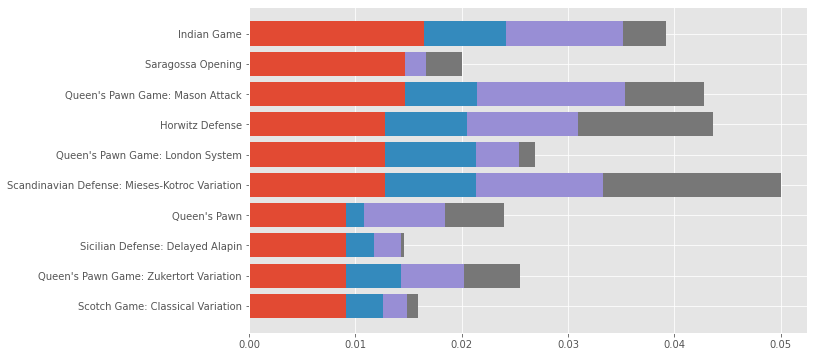

In [167]:
#top 10 master openings % played by group
fig, ax = plt.subplots(1,1, figsize = (10,6))
x_pos = [i for i in openings_grouped.index[0:10]]
b = np.array(openings_grouped['Beginner_%'][0:10])
n = np.array(openings_grouped['Novice_%'][0:10])
e = np.array(openings_grouped['Expert_%'][0:10])
m = np.array(openings_grouped['Master_%'][0:10])
ax.barh(x_pos, m)
ax.barh(x_pos, e, left = m)
ax.barh(x_pos, n, left = m + e)
ax.barh(x_pos, b, left = m + e + n)
ax.set_ylim(ax.get_ylim()[::-1]);

AttributeError: 'DataFrame' object has no attribute 'pdf'

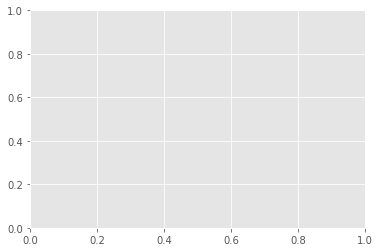

In [171]:
#distribution of ratings by group
fig,ax = plt.subplots(1,1)
x = np.linspace(600, 2800, 501)
plt.plot(x, df[(df['white_rating_value'] == 'Beginner')].pdf(x) )

In [175]:
b = df[(df['white_rating_value'] == 'Beginner') & (df['black_rating_value'] == 'Beginner')  ]
b.describe()

,created_at,last_move_at,turns,white_rating,black_rating,opening_ply,white_rating_code,black_rating_code
count,2.900000e+03,2.900000e+03,2900.000000,2900.000000,2900.000000,2900.000000,2900.0,2900.0
mean,1.477520e+12,1.477521e+12,53.686897,1225.469655,1223.113448,3.787931,1.0,1.0
std,3.291629e+10,3.291573e+10,32.591335,126.009990,128.968877,2.010886,0.0,0.0
min,1.376772e+12,1.376772e+12,2.000000,784.000000,791.000000,1.000000,1.0,1.0
25%,1.460660e+12,1.460660e+12,30.000000,1147.000000,1148.000000,2.000000,1.0,1.0
50%,1.491710e+12,1.491710e+12,50.000000,1251.000000,1247.000000,3.000000,1.0,1.0
75%,1.501990e+12,1.501990e+12,73.000000,1329.000000,1328.000000,5.000000,1.0,1.0
max,1.504484e+12,1.504485e+12,207.000000,1399.000000,1399.000000,18.000000,1.0,1.0


In [176]:
b['white_rating'].pdf(x)

AttributeError: 'Series' object has no attribute 'pdf'

In [ ]:
#distribution of white and black rating
fig, ax = plt.subplots(1,1)
x = np.linspace(df.white_rating.min(), df.white_rating.max(), 501)
plt.plot(x, white_rating_dist.pdf(x))
plt.plot(x, black_rating_dist.pdf(x))